In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import re
import glob

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn import metrics

from train0 import checksum, determine_image_center, shadow_regions

# Visualizations

Working with trained CNN models by means of: .csv prediction files, .pth files, and more!

In [63]:
def visualize_images(img_id, skel, shadow, shadow_rings, num_rings, shadow_radiuses, img_count=0): 
    
    # if doing just shadow: shadow_radiuses is radius of shadow circle
    # if doing shadow rings, shadow_rings is array of array of outer/inner ring radiuses
    
    num_images = img_count
    
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    # based on checksums, bc function is. 
    # if we get one of those duplicates/incorrect images, will manually put disk center, or change img
    
    QA_csv, checksum_dict = checksum("../../optic_disk/DeepROP/quality_assurance/QA.csv")
    disk_center = determine_image_center(img, (224, 224), QA_csv, checksum_dict) 
    
    print(disk_center)
    
    if shadow is True and shadow_rings is not True:
        num_images = len(shadow_radiuses)
    elif shadow is True and shadow_rings is True:
        num_images = len(shadow_radiuses)
    
    # write if conditions for other scenarios as I need to visualize them
    
    for i in range(num_images):
        dark_center_img = shadow_regions(img, skel, disk_center, shadow, shadow_radiuses[i], shadow_rings, num_rings,
                                         shadow_radiuses[i], 'dark_center', image_size = (224, 224))
        dark_back_img = shadow_regions(img, skel, disk_center, shadow, shadow_radiuses[i], shadow_rings, num_rings, 
                                       shadow_radiuses[i], 'dark_background', image_size = (224, 224))
        
        # bad code here
        print('dark center, ',shadow_radiuses[i])
        plt.imshow(dark_center_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()
        
        print('dark background, ',shadow_radiuses[i])
        plt.imshow(dark_back_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

100%|██████████| 3371/3371 [00:13<00:00, 254.74it/s]


dark center,  15


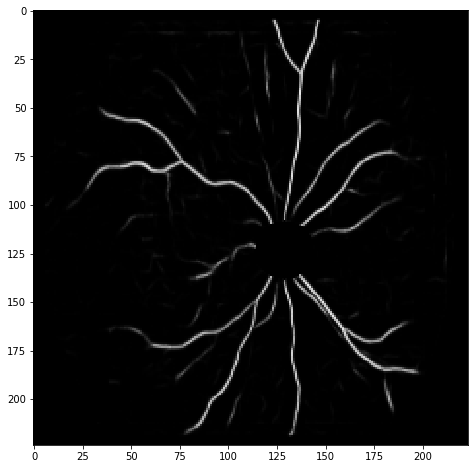

dark background,  15


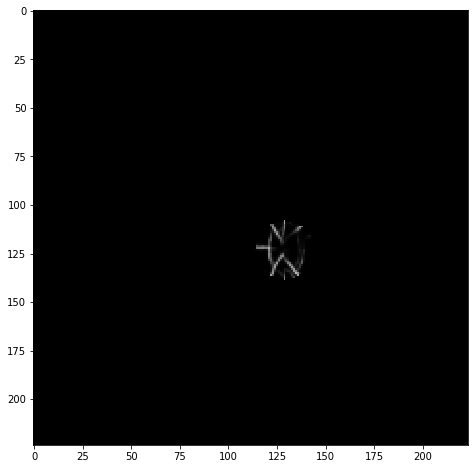

dark center,  30


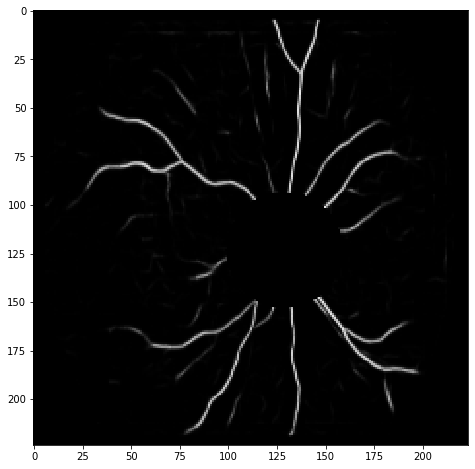

dark background,  30


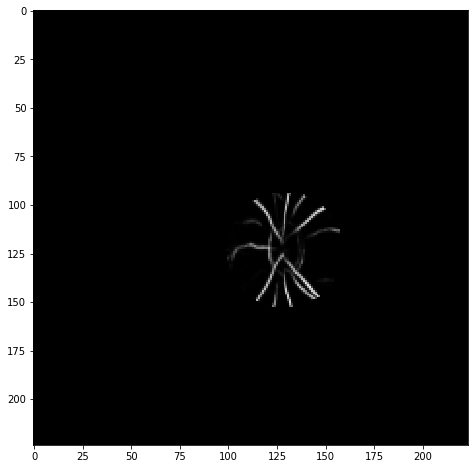

dark center,  45


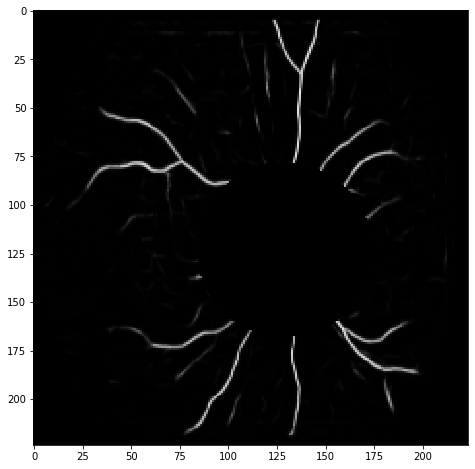

dark background,  45


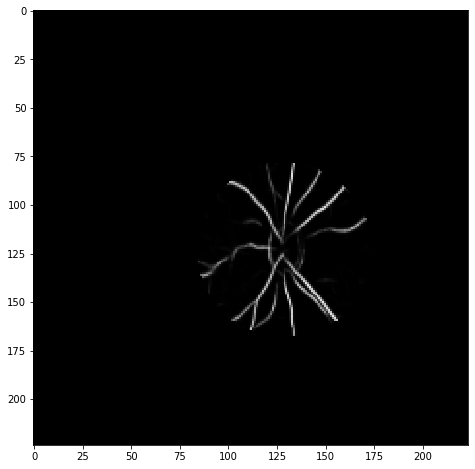

dark center,  60


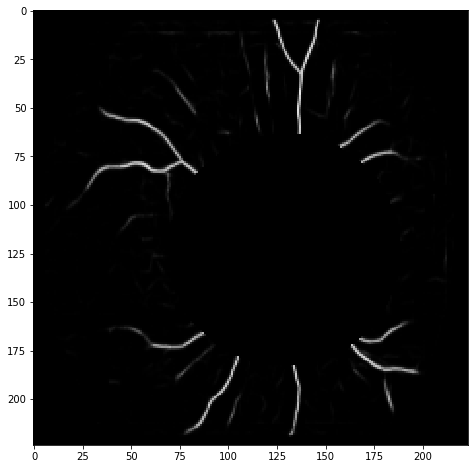

dark background,  60


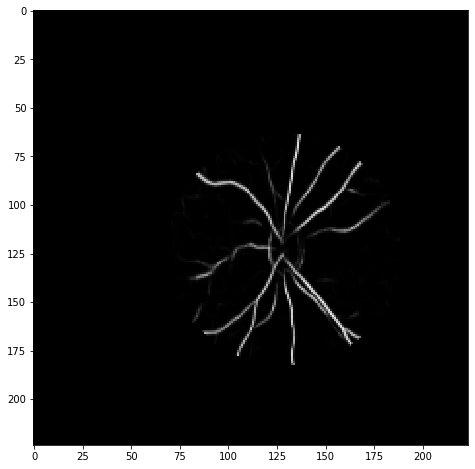

dark center,  75


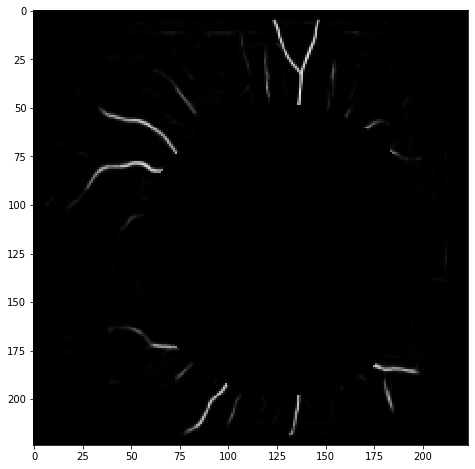

dark background,  75


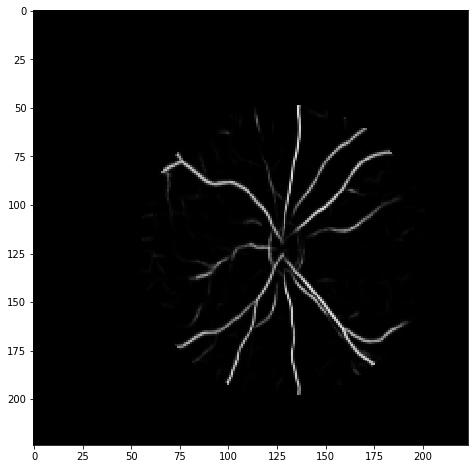

dark center,  90


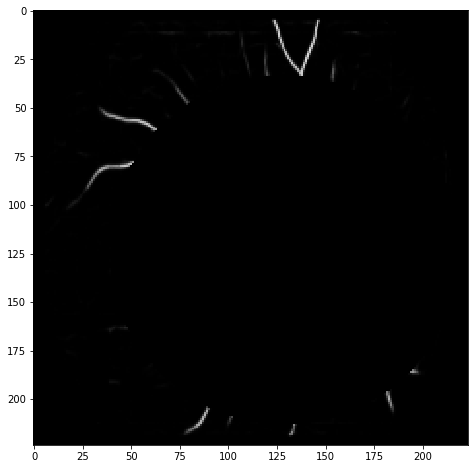

dark background,  90


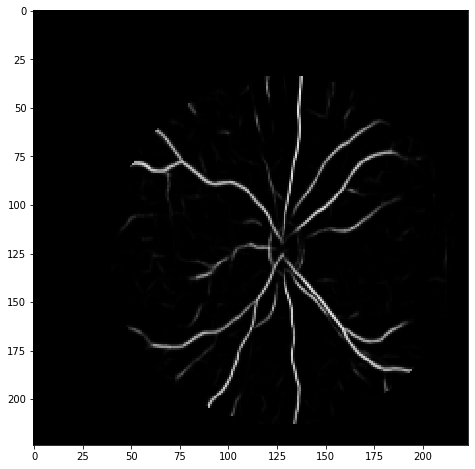

dark center,  105


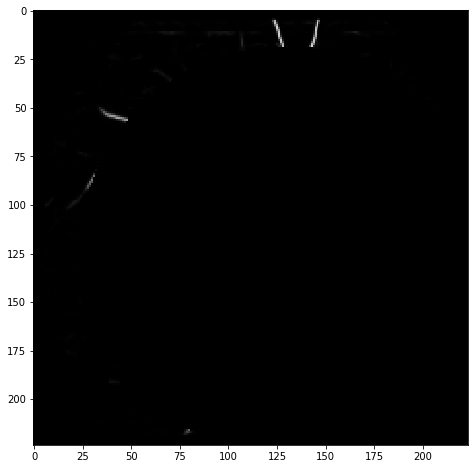

dark background,  105


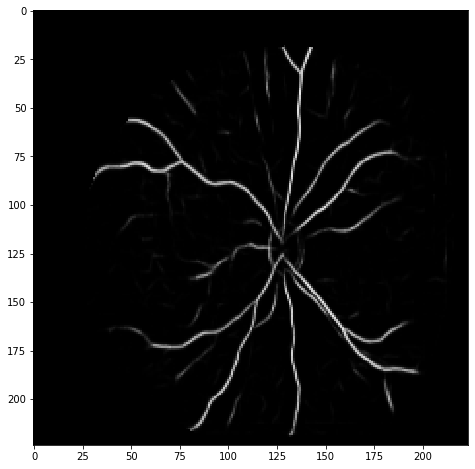

dark center,  120


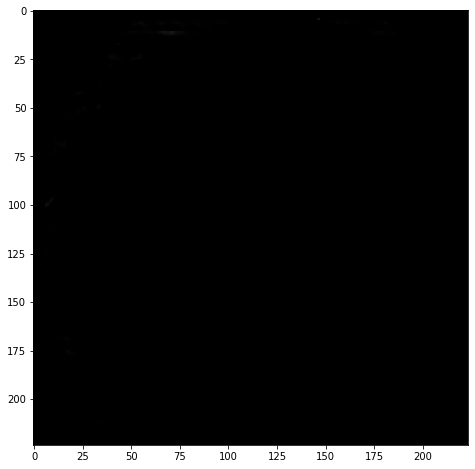

dark background,  120


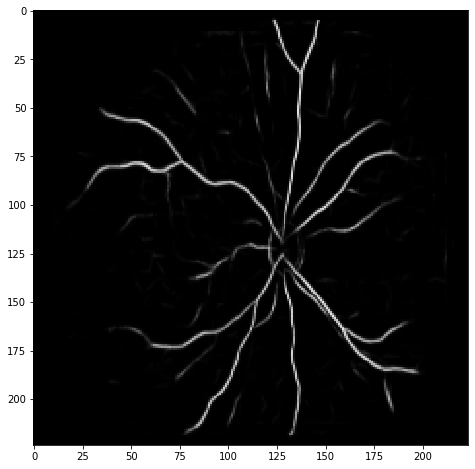

In [28]:
shadow_radiuses = [15, 30, 45, 60, 75, 90, 105, 120]
visualize_images(18168, False, True, False, 1, shadow_radiuses)

100%|██████████| 3371/3371 [00:13<00:00, 257.67it/s]


(58, 129)
dark center,  [[0, 15], [75, 90]]


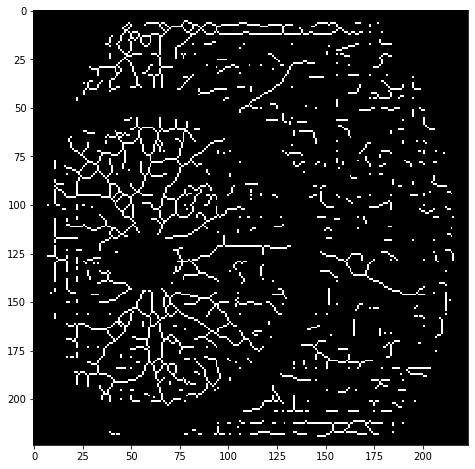

dark background,  [[0, 15], [75, 90]]


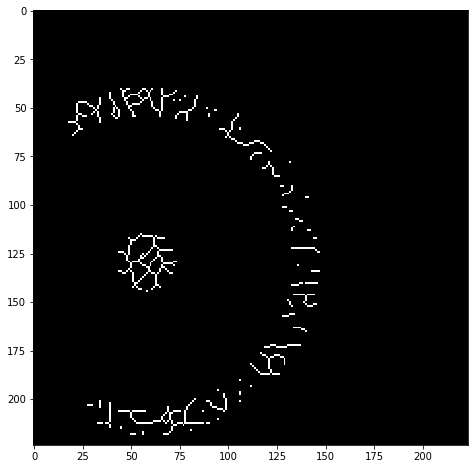

dark center,  [[0, 30], [60, 90]]


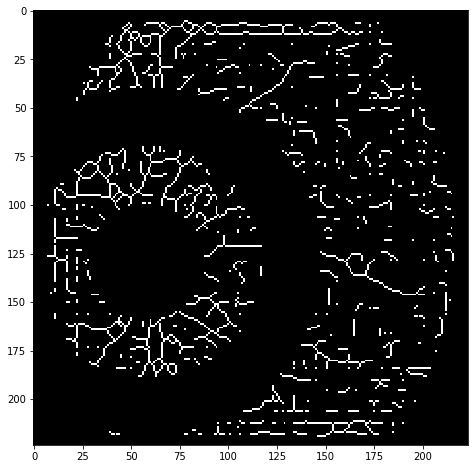

dark background,  [[0, 30], [60, 90]]


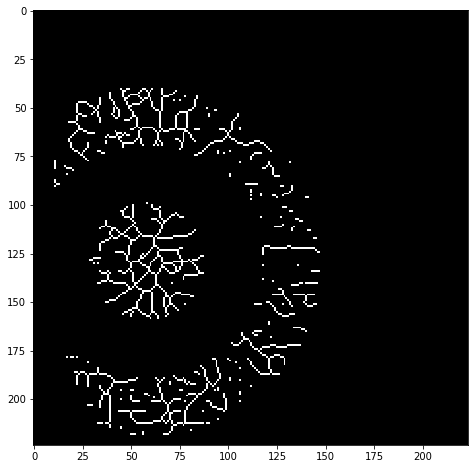

dark center,  [[0, 45], [45, 90]]


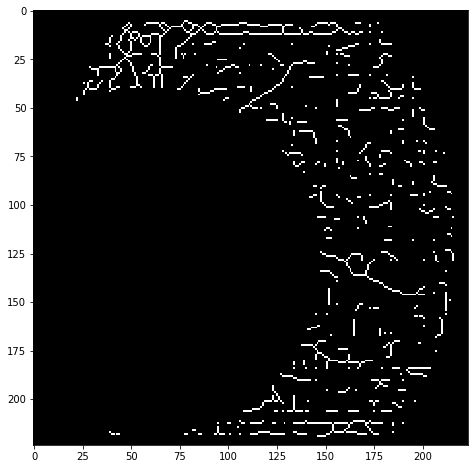

dark background,  [[0, 45], [45, 90]]


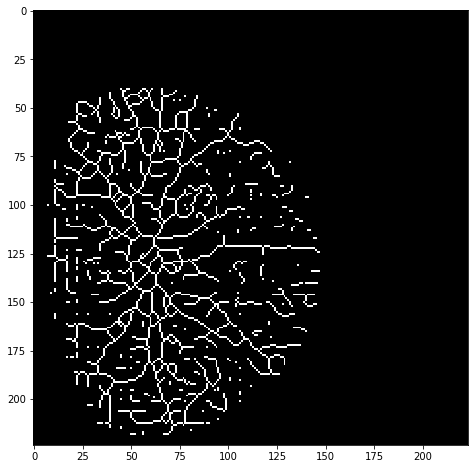

In [64]:
multi_ring_radiuses = [[[0, 15], [75,90]], [[0, 30], [60, 90]], [[0,45],[45, 90]]]
visualize_images(27313, True, True, True, 2, multi_ring_radiuses)

100%|██████████| 3371/3371 [00:10<00:00, 326.72it/s]


dark center,  [0, 30]


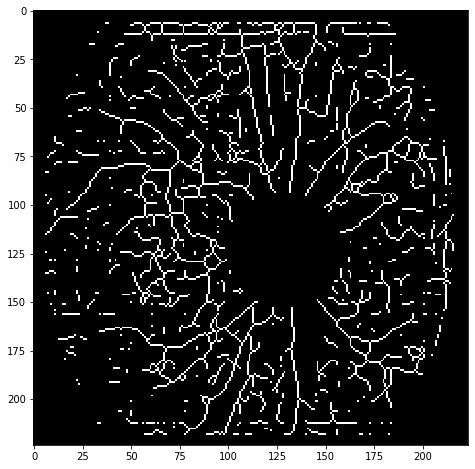

dark background,  [0, 30]


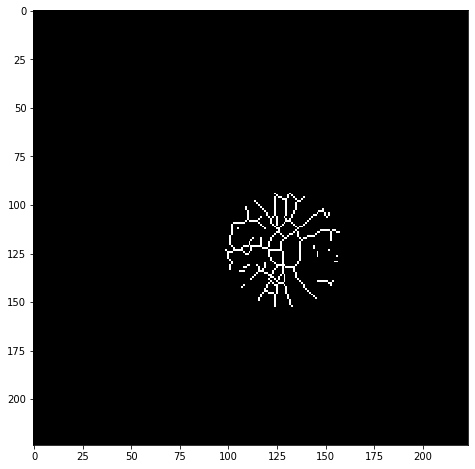

dark center,  [30, 60]


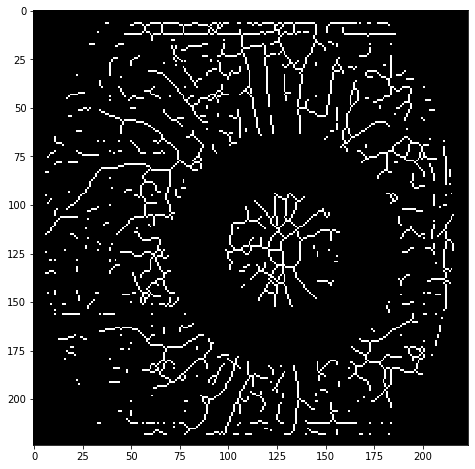

dark background,  [30, 60]


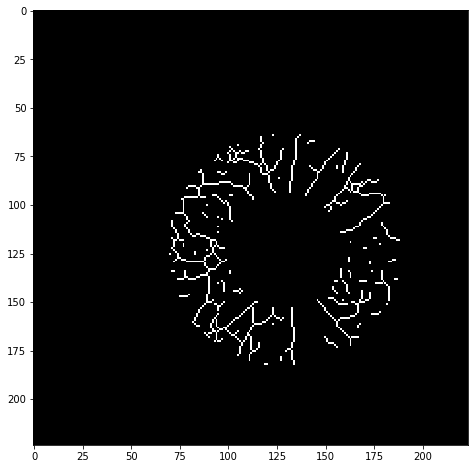

dark center,  [60, 90]


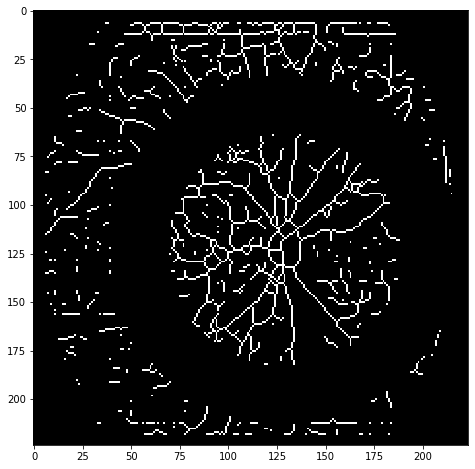

dark background,  [60, 90]


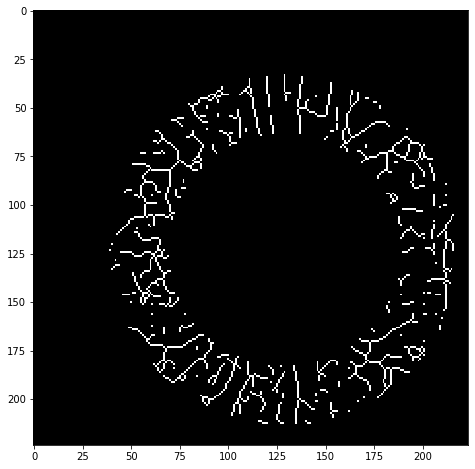

In [4]:
ring_radiuses = [[0, 30], [30, 60], [60, 90]]
visualize_images(18168, True, True, True, 1, ring_radiuses)

In [172]:
os.listdir("./outputs/probabilities/")

['shadow_rings_dark_center_75_90_skeletonized_epoch50.csv',
 'shadow_regions_dark_center_60_skeletonized_epoch50.csv',
 'shadow_rings_dark_center_30_45_epoch50.csv',
 'shadow_rings_dark_background_75_90_skeletonized_epoch50.csv',
 'shadow_regions_dark_background_45_epoch50.csv',
 'shadow_regions_dark_center_45_epoch50.csv',
 'shadow_rings_dark_background_60_75_skeletonized_epoch50.csv',
 '.ipynb_checkpoints',
 'shadow_rings_dark_center_45_60_epoch50.csv',
 'shadow_rings_dark_center_60_75_skeletonized_epoch50.csv',
 'shadow_regions_dark_center_75_epoch50.csv',
 'shadow_regions_dark_center_105_epoch50.csv',
 'shadow_regions_dark_background_75_epoch50.csv',
 'shadow_rings_dark_background_60_90_epoch50.csv',
 'shadow_rings_dark_center_75_90_epoch50.csv',
 'shadow_rings_dark_center_0_15_skeletonized_epoch50.csv',
 'shadow_rings_dark_center_45_60_skeletonized_epoch50.csv',
 'shadow_rings_dark_center_30_60_skeletonized_epoch50.csv',
 'shadow_rings_dark_background_30_60_skeletonized_epoch50.cs

In [55]:
def make_roc_plot(path, epoch, skeleton, shadow, shadow_ring, shadow_radiuses, region, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
    
    label = ''
    
    files=os.listdir(path)
    csvs = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    if skeleton:
        paths = [p for p in csvs if "skeletonized" in p or "skeletonized" in p and "shadow" not in p]
        if shadow:
            if shadow_ring:
                paths = [p for p in paths if "shadow_rings" in p or "skeletonized" in p and "shadow" not in p] # original skeletonized
            elif shadow_ring is False:
                paths = [p for p in paths if "shadow" in p and "ring" not in p or "skeletonized" in p and "shadow" not in p]
        elif shadow is False:
            paths = [p for p in paths if "skeletonized" in p and "shadow" not in p] # only original skeletonized
        
        if region == 'dark_center':
            paths = [p for p in paths if "dark_center" in p or "skeletonized" in p and "shadow" not in p]
        
        elif region == 'dark_background':
            paths = [p for p in paths if "dark_background" in p or "skeletonized" in p and "shadow" not in p]
        
    if not skeleton:
        paths = [p for p in csvs if "skeletonized" not in p or "original" in p]  
        if shadow:
            if shadow_ring:
                paths = [p for p in paths if "shadow_rings" in p or "original" in p]
            elif shadow_ring is False:
                [p for p in paths if "shadow" in p and "ring" not in p or "original" in p]
        elif shadow is False:
            [p for p in paths if "original" in p] # only original skeletonized
         
        if region == 'dark_center':
            paths = [p for p in paths if "dark_center" in p or "original" in p]
        
        elif region == 'dark_background':
            paths = [p for p in paths if "dark_background" in p or "original" in p]
    
    # narrowing down paths by radiuses I Want
    # print (len(paths))
    
    final_paths = []
    labels_arr = []
    shadow_remove = len(shadow_radiuses)

    # to improve code, can store in variables and append only at the end.
    # how to organize this such that labels and paths are in the order that I want?
    
    for j in range(len(shadow_radiuses)): # getting this original in first order.
        for i in range(len(paths)):
            
            path_nums = re.findall(r'\d+', paths[i])
            
            if len(path_nums) == 1:
                if skeleton == True and paths[i] not in final_paths:
                    labels_arr = np.append(labels_arr, "original skeletonized")
                    final_paths = np.append(final_paths, paths[i])
                elif skeleton == False and paths[i] not in final_paths:
                    labels_arr = np.append(labels_arr, "original")
                    final_paths = np.append(final_paths, paths[i])
        
    for j in range(len(shadow_radiuses)):
        for i in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[i])

            if len(path_nums) == 2: # means there is 1 radius, and no rings
                if path_nums[0] == shadow_radiuses[j] and paths[i] not in final_paths: # to get them in the order I want!!!
                    # print(path_nums[0])
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0])
                    shadow_remove -= 1

            elif len(path_nums) == 3: # means 2 radiuses, shadow rings
                radius_arr = [path_nums[0], path_nums[1]] # last is epoch number, 50
                if radius_arr == shadow_radiuses[j] and paths[i] not in final_paths:
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + " (ring)")
                    shadow_remove -= 1
            
            elif len(path_nums) == 5: # means 2 shadow rings, assuming ONLY 2
                radius_arr = [[path_nums[0], path_nums[1]], [path_nums[2], path_nums[3]]] # last is epoch number, 50
                if radius_arr == shadow_radiuses[j] and paths[i] not in final_paths:
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + 
                                           ", " + path_nums[2] + " to " + path_nums[3] + " (2 rings)")
                    shadow_remove -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        

        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        
        
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc))

    plt.legend(loc=4)
    plt.show()       

['original_epoch50.csv'
 'shadow_rings_dark_background_0_15_75_90_epoch50.csv'
 'shadow_rings_dark_background_0_30_60_90_epoch50.csv'
 'shadow_regions_dark_background_90_epoch50.csv']
['original' 'radius: 0 to 15, 75 to 90 (2 rings)'
 'radius: 0 to 30, 60 to 90 (2 rings)'
 'radius: 0 to 45, 45 to 90 (2 rings)']


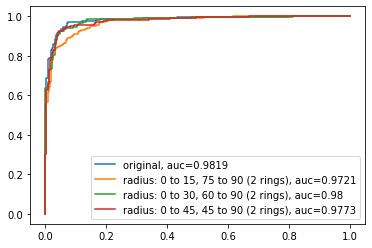

In [58]:
multi_ring_roc_radiuses = [[['0', '15'], ['75','90']], [['0', '30'], ['60', '90']], [['0','45'],['45', '90']]]

make_roc_plot("./outputs/probabilities/", 50, False, True, True, 
              multi_ring_roc_radiuses, 'dark_background',
             insert_indexes = [3], my_paths = ['shadow_regions_dark_background_90_epoch50.csv'], 
              my_labels=['radius: 0 to 45, 45 to 90 (2 rings)'])


['original skeletonized' 'radius: 15' 'radius: 30' 'radius: 45'
 'radius: 60' 'radius: 75' 'radius: 90' 'radius: 105' 'radius: 120']


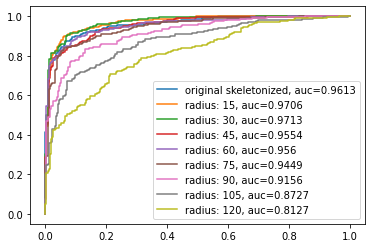

In [179]:
make_roc_plot("./outputs/probabilities/", 50, True, True, False, 
              ['15', '30', '45', '60', '75', '90', '105', '120'], 'dark_center',
             [1, 2], ['shadow_rings_dark_center_0_15_skeletonized_epoch50.csv', 
                      'shadow_rings_dark_center_0_30_skeletonized_epoch50.csv'], 
             ['radius: 15', 'radius: 30'])

# how does the code even work to make original come first?

11
['shadow_rings_dark_background_30_60_skeletonized_epoch50.csv'
 'shadow_rings_dark_background_0_30_skeletonized_epoch50.csv'
 'skeletonized_epoch50.csv'
 'shadow_rings_dark_background_60_90_skeletonized_epoch50.csv']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']


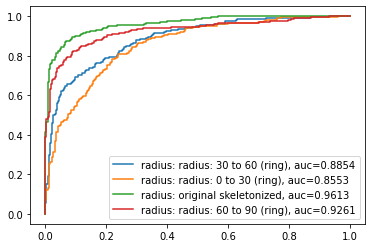

In [96]:
make_roc_plot("./outputs/probabilities/", 50, True, True, True, [['0', '30'], ['30','60'], ['60', '90']], 'dark_background')